---------------

##  Wrangle and Analyze <span style="color:green">@WeRateDogs </span> Twitter account

Started: 10/03/2019  
Last Update: 06/04/2018  
Eudald Escribà     [  GitHub  ](https://escrap.github.com)

----------------

<div id='top' /> 

***Table of contents***


1. [Introduction](#id1)


2. [Library import](#id2)


3. [Gathering Data](#id3)
  *  [Read in Twitter Archive with enhanced Data](#id31)
  *  [Read image prediction .tsv from an URL](#id32)
  *  [Read Twitter account via API](#id33) 
 
  
4. [Assessing Data](#id4)
  * [General observation](#id41)
  * [Data quality dimensions observation](#id42) 
      * [Completeness](#id421)
      * [Validity](#id422)
      * [Accuracy](#id423)
      * [Consistency](#id424)
  * [Data tidiness observation](#id43)       
  * [Summary of data assesment](#id44)
      * [Quality Issues (to be fixed)](#id441)
      * [Tidiness Issues (to be fixed)](#id442)  
      
      
5. [Data cleaning](#id5)
      * [Missing values in expanded_urls](#id51)
      * [Remove any tweet ids in the archive table that aren't in the predictions table](#id52)
      * [Merge the 2 dataframes corresponding to tweet information to the same dataframe](#id53)
      * [There are missing dog names (they appear as None)](#id54) 
      * [There are denominators different to 10 ](#id55)
      * [Numerators can be extremely away from 10](#id56) 
      * [Convert timestamp and retweeted_status_timestamp to data type datetime](#id57)
      * [p1, p2, p3 have some accuarcy spelling mistakes. Not always first letter is capital/lower](#id58)
      * [There are multiple columns containing the same variable. Dog Type appear in three columns doggo, floofer, pupper and puppo](#id59)
      * [Merge the two df in one called twitter_archive_master_df](#id510) 
      * [Source twitter_archive_master_df shorting](#id511) 
      
      
6. [Storage/save Master df](#id6)


7. [Data Visualizations and Analyses](#id7)
      * [Is there a main way to tweet? Which source uses?](#id71)
      * [Which are the most added to favorites Internet_dog_terminology growing stages?](#id72)
      * [Which are the most retweeted Internet_dog_terminology growing stages?](#id73)
      * [Is there a correlation between retweets and  additions to favorites?](#id74) 
      * [Which is the highest Internet_dog_terminology in terms of  average rating?](#id75)
      * [The most popular dog names are the names of the most retweeted dogs?](#id76)       

---

<div id='id1' />

### **1. Introduction**

>The project consists of gathering, assessing, cleaning, storing, and finally analyzing and visualizing the tweet history of the famous twitter account WeRateDogs.

<div id='id2' />

### **2. Library import**

In [1]:
# Loading libraries

import pandas as pd
import numpy as np
import requests
import os
import tweepy
import time
import json
import datetime
import string

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<div id='id3' />

### **3. Gathering Data** 


The data come from three sources, a manually downloaded csv file, a programmatically downloaded tsv file and using the Twitter API.

<div id='id31' />


>**3.1 Read in Twitter Archive with enhanced Data**

In [2]:
# After uploading to the directory where this Notebook is, we can directly access it. 
# The name is: twitter_archive_enhanced.csv

archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')
archive_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


<div id='id32' />

>**3.2 Read image prediction .tsv from an URL**

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [3]:
# Create directory if it doesn't exist 
name_folder = 'image_predictions'
if not os.path.exists(name_folder):
    os.makedirs(name_folder)

In [4]:
# Get data from url and keep it in a variable called response
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
# checking for a <Response [200]>
response

<Response [200]>

In [5]:
# See the content in binary
response.content

b"tweet_id\tjpg_url\timg_num\tp1\tp1_conf\tp1_dog\tp2\tp2_conf\tp2_dog\tp3\tp3_conf\tp3_dog\n666020888022790149\thttps://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg\t1\tWelsh_springer_spaniel\t0.465074\tTrue\tcollie\t0.156665\tTrue\tShetland_sheepdog\t0.0614285\tTrue\n666029285002620928\thttps://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg\t1\tredbone\t0.506826\tTrue\tminiature_pinscher\t0.07419169999999999\tTrue\tRhodesian_ridgeback\t0.07201\tTrue\n666033412701032449\thttps://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg\t1\tGerman_shepherd\t0.596461\tTrue\tmalinois\t0.13858399999999998\tTrue\tbloodhound\t0.11619700000000001\tTrue\n666044226329800704\thttps://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg\t1\tRhodesian_ridgeback\t0.408143\tTrue\tredbone\t0.360687\tTrue\tminiature_pinscher\t0.222752\tTrue\n666049248165822465\thttps://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg\t1\tminiature_pinscher\t0.560311\tTrue\tRottweiler\t0.243682\tTrue\tDoberman\t0.154629\tTrue\n666050758794694657\thttps://pbs.twimg.com/

In [6]:
# Create the  file 
with open(os.path.join(name_folder, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)
     

In [7]:
#and now,read the text file and create a dataframe named dog_predictions

dog_predictions = pd.read_csv('image_predictions/image-predictions.tsv', sep='\t')
dog_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<div id='id33' />

>**3.3 Read Twitter account via API**

In [8]:
# the following code, which is provided in the Getting started portion of the Tweepy documentation, 
# will create an API object that we can use to gather Twitter data.

consumer_key='mSWxjuVU1Vr5joR56Ncb4Iyk8'
consumer_secret='REPmOAzwr9UlsKnHvdNmjFMriBpQcEq8aClmebIuFdd40TNgKk'

access_token='1055804373467623425-EBOwt17JikaJdFPr2Bi9KUNT4Xrm7k'
access_token_secret='0yv3cowB6jqhcQFCpZOcoit2OBfYkSkAU7Ph1HIAd8EFJ'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# set Twitter's rate limit. API created!!
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [9]:
# take a look at one tweet (the first, for example) 
 
tweet = api.get_status(archive_enhanced['tweet_id'][0], tweet_mode='extended')
#info included 
tweet.__dict__.keys()

dict_keys(['_api', '_json', 'created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'source_url', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'author', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [10]:
# get informations about the tweet, for example

print(tweet.retweet_count ,'---------------' , tweet.full_text )


8213 --------------- This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU


In [11]:
# or even the complete json info
tweet._json

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 

In [12]:
# Now we are asked to write every piece of info in a line of a txt file called

# tweet_json.txt

# so, create the file if it doesn't already exist

file_name = 'tweet_json.txt'
if not os.path.isfile(file_name):
    open(file_name, 'w').close()

Now we imagine a tweet , concretely a JSON stucture of the tweet. That is for us a dictionary.
And every tweet is a new dictionary. So, we have a kind of database that is a list of dictionaries.

In [13]:

# Imoving along tweet_id column from the archive_enhanced dataframe and I  do 2 things.

start_time = time.time()

dictionaries_list = [] # prepare the continent for the list of dictionaries (tweets)
errors = [] # keep the errors during the process

# First, get the status ( catching the tweet) of evry one

# Second, create the list with one dictionary every time. Only for the things  considered important ( terms of analyse)

# tweets id, favorite count, and retweet count.


for id in archive_enhanced['tweet_id']:
    try:
        tweet = api.get_status(id, tweet_mode='extended')
        dictionaries_list.append({'tweet_id': str(tweet.id),
                        'retweet_count': int(tweet.retweet_count),         
                        'favorite_count': int(tweet.favorite_count)})
    except Exception as e:
        print('Failure with tweet with ID: {}. Error: {}'. format(str(id), str(e)))
        errors.append(id)
        
print("\nThis took %s seconds." % (time.time() - start_time))


Failure with tweet with ID: 888202515573088257. Error: [{'code': 144, 'message': 'No status found with that ID.'}]
Failure with tweet with ID: 873697596434513921. Error: [{'code': 144, 'message': 'No status found with that ID.'}]
Failure with tweet with ID: 872668790621863937. Error: [{'code': 144, 'message': 'No status found with that ID.'}]
Failure with tweet with ID: 872261713294495745. Error: [{'code': 144, 'message': 'No status found with that ID.'}]
Failure with tweet with ID: 869988702071779329. Error: [{'code': 144, 'message': 'No status found with that ID.'}]
Failure with tweet with ID: 866816280283807744. Error: [{'code': 144, 'message': 'No status found with that ID.'}]
Failure with tweet with ID: 861769973181624320. Error: [{'code': 144, 'message': 'No status found with that ID.'}]
Failure with tweet with ID: 845459076796616705. Error: [{'code': 144, 'message': 'No status found with that ID.'}]
Failure with tweet with ID: 842892208864923648. Error: [{'code': 144, 'message':

In [14]:
# returns the number of errors 
len(errors)

17

In [15]:
# create a txt file and  save the list of dictionaries in a json formatted txt file. 

# The reason to use json.dump can be found here:

# https://stackoverflow.com/questions/25778021/how-can-i-save-a-list-of-dictionaries-to-a-file

# provided that the object only contains objects that JSON can handle 

# (lists, tuples, strings, dicts, numbers, None, True and False),  can dump it as json.dump:

with open('tweet_json.txt', 'w') as out_file:  # dump the string in a text file
    json.dump(dictionaries_list, out_file) # create a string from json

In [16]:
# Last step, json txt file json formatted into a dataframe named json_twitter

with open('tweet_json.txt', 'r') as file: 
    json_twitter = pd.DataFrame(json.load(file), columns=['tweet_id', 'favorite_count', 'retweet_count'])

In [17]:
json_twitter.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37692,8213
1,892177421306343426,32377,6074
2,891815181378084864,24379,4016
3,891689557279858688,41010,8370
4,891327558926688256,39207,9074


In [18]:
# save the dataframe to csv to avoid looping after a refresh

json_twitter.to_csv('api_twitter.csv', encoding='utf-8')

<div id='id4' />

### **4. Assessing Data** 

This section details my assessment of the data with regard to **quality and tidiness**. The general approach will be to assess with regard to the following definitnions of those terms.

 **Quality issues pertain to content.** Low quality data is also known as dirty data. There are four dimensions of quality data:

- **Completeness:** do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?

- **Validity:** we have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).

- **Accuracy:** inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.

- **Consistency:** inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

**Tidiness issues pertain to structure.** These structural problems generally prevent easy analysis. Untidy data is also known as messy data. The requirements for tidy data are:

- Each variable forms a column.
- Each observation forms a row.
- Each type of observational unit forms a table.

<div id='id41' />

**4.1.General observation** 

In [19]:
#array with column labels 
archive_enhanced.columns.values

array(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

In [20]:
#array with column labels
dog_predictions.columns.values

array(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], dtype=object)

In [21]:
#array with column labels
json_twitter.columns.values

array(['tweet_id', 'favorite_count', 'retweet_count'], dtype=object)

In [22]:
# see random rows
archive_enhanced.sample(6)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
855,764857477905154048,NaN,NaN,2016-08-14 16:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Aubie. He has paws for days. Nibbling ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/764857477...,12,10,Aubie,None,None,None,None
317,834786237630337024,NaN,NaN,2017-02-23 15:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tobi. She is properly fetching her sho...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834786237...,13,10,Tobi,None,None,None,None
937,753298634498793472,NaN,NaN,2016-07-13 18:42:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Carly. She's actually 2...,6.815232e+17,4.196984e+09,2015-12-28 17:12:42 +0000,https://twitter.com/dog_rates/status/681523177...,12,10,Carly,None,None,None,None
2284,667192066997374976,NaN,NaN,2015-11-19 04:05:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*takes several long deep breaths* omg omg oMG ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667192066...,12,10,None,None,None,None,None
2297,667073648344346624,NaN,NaN,2015-11-18 20:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is Dave. He is actually just a skinny leg...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667073648...,10,10,Dave,None,None,None,None
1226,713919462244790272,NaN,NaN,2016-03-27 02:43:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kanu. He's a Freckled Ticonderoga. Sim...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713919462...,12,10,Kanu,None,None,None,None


In [23]:
# 4 random rows
dog_predictions.sample(6)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
556,677673981332312066,https://pbs.twimg.com/media/CWeU5LBWEAA8F0J.jpg,1,Maltese_dog,0.817908,True,Angora,0.077805,False,Pomeranian,0.022184,True
1971,869227993411051520,https://pbs.twimg.com/media/DBAePiVXcAAqHSR.jpg,1,Pembroke,0.664181,True,Chihuahua,0.169234,True,Cardigan,0.132700,True
658,682389078323662849,https://pbs.twimg.com/media/CXhVKtvW8AAyiyK.jpg,1,curly-coated_retriever,0.482288,True,flat-coated_retriever,0.315286,True,Great_Dane,0.062179,True
1976,870308999962521604,https://pbs.twimg.com/media/DBP1asiUAAEKZI5.jpg,2,Greater_Swiss_Mountain_dog,0.622752,True,Appenzeller,0.158463,True,EntleBucher,0.148115,True
1503,784826020293709826,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True
401,673689733134946305,https://pbs.twimg.com/media/CVltNgxWEAA5sCJ.jpg,1,Chesapeake_Bay_retriever,0.382220,True,American_Staffordshire_terrier,0.350140,True,seat_belt,0.098874,False


In [24]:
# 4 random rows
json_twitter.sample(6)

,tweet_id,favorite_count,retweet_count
348,830097400375152640,10263,3201
1884,674646392044941312,1454,509
515,808733504066486276,8387,2352
315,833863086058651648,13979,2550
1600,685198997565345792,2427,702
1313,705898680587526145,2458,583


<div id='id42' />

**4.2.Data quality dimensions observation** 

Color codification:

<span style="color:green">**Completeness**</span>   
<span style="color:purple">**Validity**</span>  
<span style="color:blue">**Accuracy**</span>  
<span style="color:red">**Consistency**</span>

<div id='id421' />

>**4.2.1 Completeness**


Do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?

In [25]:
# get info from dataframes
archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

><span style="color:green"> There are  -2297 expanded_urls non-null object-, so there are missing values</span>

In [26]:
# get info from dataframes
dog_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
# get info from dataframes
json_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id          2339 non-null object
favorite_count    2339 non-null int64
retweet_count     2339 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


In [28]:
# rows in every datafre count

print( 'The number of rows in the dataframes are:' )
print('archive_enhanced :{}'. format(archive_enhanced.index[-1]+1))
print('dog_predictions :{}'. format(dog_predictions.index[-1]+1))
print('json_twitter :{}'. format(json_twitter.index[-1]+1))


The number of rows in the dataframes are:
archive_enhanced :2356
dog_predictions :2075
json_twitter :2339


><span style="color:green">It would seem logical to think that these imbalances should have an explanation. In any case, the fact is that having a different number of rows, of tweets, becomes a  case of uncompleteness.</span>

In [29]:
# Discussion

# are all the tweets from json_twitter in enhanced_archive? and the other way round?

a= json_twitter.tweet_id.isin(archive_enhanced.tweet_id).all()
print('Asserting that all of the tweets from json_twitter are in the archive_enhanced dataframe : {}'.format(a))
print()

b= archive_enhanced.tweet_id.isin(json_twitter.tweet_id).all()
print('Asserting that all of the tweets from archive_enhanced are in the json_twitter dataframe : {} '. format(b))
print()
c= -len(json_twitter)+len(archive_enhanced)
print('It is logic to think that some  of the tweets, specifically {} , have been deleted in the time from archive_enhanced dataframe was extracted and our via API consultation.'. format(c))


Asserting that all of the tweets from json_twitter are in the archive_enhanced dataframe : False

Asserting that all of the tweets from archive_enhanced are in the json_twitter dataframe : False 

It is logic to think that some  of the tweets, specifically 17 , have been deleted in the time from archive_enhanced dataframe was extracted and our via API consultation.


In [30]:
# Discussion

# are all the tweets from dog_predictions in enhanced_archive? and in the json_twitter? 

a= dog_predictions.tweet_id.isin(archive_enhanced.tweet_id).all()
print('Asserting that all of the tweets from dog_predictions are in the archive_enhanced dataframe : {}'.format(a))
print()
b= dog_predictions.tweet_id.isin(json_twitter.tweet_id).all()
print('Asserting that all of the tweets from dog_predictions are in the json_twitter dataframe : {}'.format(b))
print()
print('It is logic to think that in the proces to create the dog_predictions df all of the tweet_id where in the original enhanced table, but after some deletions are not in the actual json')

Asserting that all of the tweets from dog_predictions are in the archive_enhanced dataframe : True

Asserting that all of the tweets from dog_predictions are in the json_twitter dataframe : False

It is logic to think that in the proces to create the dog_predictions df all of the tweet_id where in the original enhanced table, but after some deletions are not in the actual json


<div id='id422' />

>**4.2.2 Validity** 

We have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).


In [31]:
# investigate the ratios. First denominators

(archive_enhanced['rating_denominator'] == 10 ).value_counts()


True     2333
False      23
Name: rating_denominator, dtype: int64

In [32]:
# investigate the ratios. First denominators

archive_enhanced.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [33]:
# investigate the ratios. Numerators.

(archive_enhanced['rating_numerator'] < 10 ).value_counts()

False    1916
True      440
Name: rating_numerator, dtype: int64

In [34]:
# investigate the ratios. Numerators.

archive_enhanced.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [35]:
len(archive_enhanced.query('rating_numerator > rating_denominator'))

1451

But,...

In [36]:
len(archive_enhanced.query('rating_numerator < rating_denominator'))

442

- <span style="color:purple">There are denominators different to 10</span>  
- <span style="color:purple">Numerators can be extremely large or under 10</span>  

<div id='id423' />

>**4.2.3 Accuracy** 

Inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.

In [37]:
# investigation name values ( stings )

archive_enhanced.name.value_counts().head(25)

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
Oliver      11
Lola        10
Penny       10
Tucker      10
Bo           9
Winston      9
Sadie        8
the          8
Toby         7
Buddy        7
Daisy        7
Bailey       7
an           7
Koda         6
Jack         6
Stanley      6
Jax          6
Rusty        6
Leo          6
Milo         6
Name: name, dtype: int64

 - <span style="color:blue">Observation let see that some names are not rally names. **a, an** are good examples.</span> 

In [38]:
# lokk for other columns with possible spelling inaccuracies

dog_predictions.p1.head(20)

0     Welsh_springer_spaniel
1                    redbone
2            German_shepherd
3        Rhodesian_ridgeback
4         miniature_pinscher
5       Bernese_mountain_dog
6                 box_turtle
7                       chow
8              shopping_cart
9           miniature_poodle
10          golden_retriever
11             Gordon_setter
12              Walker_hound
13                       pug
14                bloodhound
15                     Lhasa
16            English_setter
17                       hen
18          desktop_computer
19         Italian_greyhound
Name: p1, dtype: object

 - <span style="color:blue">p1, p2, p3 have some accuarcy spelling mistakes. Not always first letter is capital or huge presence of underscores.</span> 

<div id='id424' />

>**4.2.4 Consistency** 

Inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.

In [39]:
# investigate datatypes

archive_enhanced.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

- <span style="color:red">retweeted_status_timestamp and timestamp appear as object instead of datetimes </span> 

<div id='id43' />

**4.3.Data tidiness observation** 

These structural problems generally prevent easy analysis. Untidy data is also known as messy data. The requirements for tidy data are:

- Each variable forms a column.
- Each observation forms a row.
- Each type of observational unit forms a table.

In [40]:
# checking multiple columns for the same variable
archive_enhanced.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [41]:
# checking multiple columns for the same variable
archive_enhanced.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [42]:
# checking multiple columns for the same variable
archive_enhanced.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [43]:
# checking multiple columns for the same variable
archive_enhanced.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [44]:
# checking multiple columns for the same variable
archive_enhanced.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


- <span style="color:black">There are multiple columns containing the same variable. Dog Type appear in three columns doggo, floofer, pupper and puppo.</span>

In [45]:
# check tidiness issues in the json_twitter data frame

json_twitter.head(2)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37692,8213
1,892177421306343426,32377,6074


- <span style="color:black">No tididness issues</span> 

<div id='id44' />

**4.4.Summary of data assesment** 

<div id='id441' />

>**4.4.1 Quality Issues (to be fixed)** 

Color codification:

<span style="color:green">**Completeness**</span>   
<span style="color:purple">**Validity**</span>  
<span style="color:blue">**Accuracy**</span>  
<span style="color:red">**Consistency**</span>

##### **archive_enhanced**    **(df)**

- <span style="color:green">There are  2297 expanded_urls non-null object, so there are missing values</span> (done 5.1)
- <span style="color:green">There are missing dog names (they appear as None)  </span> (done 5.4)
- <span style="color:purple">There are denominators different to 10</span>  ( done 5.5)
- <span style="color:purple">Numerators can be extremely away from 10</span>  (done 5.6)
- <span style="color:blue">Observation let see that some names are not rally names. **a, an** are good examples.</span> (done 5.3)
- <span style="color:red">retweeted_status_timestamp and timestamp appear as object instead of datetimes </span> (done 5.7) 

##### **dog_predictions** **(df)**

- <span style="color:green">missing data (only has 2075 entries instead of 2356)</span> (done 5.2)
- <span style="color:blue">p1, p2, p3 have some accuarcy spelling mistakes. Not always first letter is capital/lower.</span> (done 5.8)


##### **json_twitter** **(df)**

- <span style="color:green">missing data (only has 2339 entries instead of 2356).</span> (done 5.2)


##### **twitter_archive_master_df**    **(df)**
- <span style="color:green">Source twitter_archive_master_df shorting</span> (done 5.11)

<div id='id442' />

>**4.4.2 Tidiness Issues (to be fixed)** 

##### **archive_enhanced** **(df)**

- <span style="color:black">There are multiple columns containing the same variable. Dog Type appear in three columns doggo, floofer, pupper and puppo.</span> (done 5.9)

##### **dog_predictions** **(df)**

- <span style="color:black">No tididness issues</span> 

##### **json_twitter** **(df)**

- <span style="color:black">No tididness issues</span> 

Finally, a common tidines issue is that the dataframes archive_enhanced and json_twitter contain information about tweets, so they ara the same observation and they would be in a seme dataframe  (done 5.3) and mergin the three of them in a single dataframe named twitter_archive_master_df (done 5.10)

<div id='id5' />

### **5. Data Cleaning** 

Cleaning is the third step in the data wrangling process:

- Gather
- Assess
- Clean

There are two types of cleaning:

- Manual (not recommended unless the issues are one-off occurrences)
- Programmatic

The programmatic data cleaning process:

- Define: convert our assessments into defined cleaning tasks. These definitions also serve as an instruction list so others (or yourself in the future) can look at your work and reproduce it.
- Code: convert those definitions to code and run that code.
- Test: test your dataset, visually or with code, to make sure your cleaning operations worked.

Always make copies of the original pieces of data before cleaning!

In [46]:
archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')
archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [47]:
dog_predictions = pd.read_csv('image_predictions/image-predictions.tsv', sep='\t')
dog_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [48]:
json_twitter = pd.read_csv('api_twitter.csv')
json_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 4 columns):
Unnamed: 0        2339 non-null int64
tweet_id          2339 non-null int64
favorite_count    2339 non-null int64
retweet_count     2339 non-null int64
dtypes: int64(4)
memory usage: 73.2 KB


In [49]:
# Make copies to preserve the original datasets
archive_enhanced_clean=archive_enhanced.copy()
dog_predictions_clean=dog_predictions.copy()
json_twitter_clean=json_twitter.copy()

<div id='id51' />

**5.1.** Missing values in expanded_urls

**Define**

There are 2297 expanded_urls non-null object, so there are missing values. Use tweet_id to add the number at the end of the url beggining pattern https://twitter.com/dog_rates/status/.....

**Code**

In [50]:
# We are going to create a function to loop the column and when expanded_urls is null, add number (tweet_id) by using 
# tweet id column
#**HELP** pandas.DataFrame.apply: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

def add_tweetID(cell_value):
    # if cell is not null, do nothg
    if pd.notnull(cell_value['expanded_urls']):
        return cell_value
    else:
        # Get tweet_id from tweet_id column
        tweet_id = cell_value['tweet_id']
        # Extend the root url
        cell_value['expanded_urls'] = 'https://twitter.com/dog_rates/status/{}'.format(tweet_id)
        # return updated row
        return cell_value


# Update clean dataframe 
archive_enhanced_clean = archive_enhanced_clean.apply(add_tweetID, axis=1)

**Test**

In [51]:
archive_enhanced_clean['expanded_urls'].isnull().value_counts()

False    2356
Name: expanded_urls, dtype: int64

<div id='id52' />

**5.2.** Remove any tweet ids in the archive table that aren't in the predictions table

**Define**

Als there is missing data (only has 2339 entries instead of 2356) and  , as well, missing data (only has 2075 entries instead of 2356) in dataframes dog_predictions and json_twitter, We are goig to keep the intersecction of them and keep the minimum subset.

**Code**

In [52]:
print('archive_enhanced_clean tweet count = ' + str(len(archive_enhanced_clean)))
print('dog_predictions_clean tweet count = ' + str(len(dog_predictions_clean)))
print('json_twitter_clean tweet count = ' + str(len(json_twitter_clean)))

archive_enhanced_clean tweet count = 2356
dog_predictions_clean tweet count = 2075
json_twitter_clean tweet count = 2339


In [53]:
json_twitter_clean.head(3)

,Unnamed: 0,tweet_id,favorite_count,retweet_count
0,0,892420643555336193,37692,8213
1,1,892177421306343426,32377,6074
2,2,891815181378084864,24379,4016


In [54]:
# Create a list https://www.interviewqs.com/ddi_code_snippets/get_list_pandas_dataframe

tweets_id_keep = dog_predictions_clean['tweet_id'].tolist()
len(tweets_id_keep)

2075

In [55]:
tweets_id_keep

[666020888022790149,
 666029285002620928,
 666033412701032449,
 666044226329800704,
 666049248165822465,
 666050758794694657,
 666051853826850816,
 666055525042405380,
 666057090499244032,
 666058600524156928,
 666063827256086533,
 666071193221509120,
 666073100786774016,
 666082916733198337,
 666094000022159362,
 666099513787052032,
 666102155909144576,
 666104133288665088,
 666268910803644416,
 666273097616637952,
 666287406224695296,
 666293911632134144,
 666337882303524864,
 666345417576210432,
 666353288456101888,
 666362758909284353,
 666373753744588802,
 666396247373291520,
 666407126856765440,
 666411507551481857,
 666418789513326592,
 666421158376562688,
 666428276349472768,
 666430724426358785,
 666435652385423360,
 666437273139982337,
 666447344410484738,
 666454714377183233,
 666644823164719104,
 666649482315059201,
 666691418707132416,
 666701168228331520,
 666739327293083650,
 666776908487630848,
 666781792255496192,
 666786068205871104,
 666804364988780544,
 666817836334

In [56]:
# Hom many of them are included in archive_enhanced_clean dataframe?
archive_enhanced_clean[archive_enhanced_clean.tweet_id.isin(tweets_id_keep)]
archive_enhanced_clean[archive_enhanced_clean.tweet_id.isin(tweets_id_keep)].shape

(2075, 17)

In [57]:
# How many of them are included in json_twitter_clean_dataframe? 
json_twitter_clean[json_twitter_clean.tweet_id.isin(tweets_id_keep)]
json_twitter_clean[json_twitter_clean.tweet_id.isin(tweets_id_keep)].shape

(2066, 4)

In [58]:
# we generate a list of tweets that are both in dog_predictions and json_twitter
tweets_id_keep_intr=json_twitter_clean[json_twitter_clean.tweet_id.isin(tweets_id_keep)]['tweet_id'].tolist()

In [59]:
# looks like....
tweets_id_keep_intr

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886258384151887873,
 885984800019947520,
 885528943205470208,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046086144,
 882992080364220416,
 882762694511734784,
 882627270321602560,
 882268110199369728,
 882045870035

In [60]:
# witha length of:
len(tweets_id_keep_intr)

2066

In [61]:
# we convert our archive_enhanced dataframe in a shortlisted dataframe usin the common ones
archive_enhanced_clean[archive_enhanced_clean.tweet_id.isin(tweets_id_keep_intr)]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [62]:
# we convert our json_twitter_clean dataframe in a shortlisted dataframe usin the common ones
json_twitter_clean[json_twitter_clean.tweet_id.isin(tweets_id_keep_intr)].head()

,Unnamed: 0,tweet_id,favorite_count,retweet_count
0,0,892420643555336193,37692,8213
1,1,892177421306343426,32377,6074
2,2,891815181378084864,24379,4016
3,3,891689557279858688,41010,8370
4,4,891327558926688256,39207,9074


**Test**

In [63]:
#Intersection

print('-rows in archive_enhanced_clean : {}'.format (archive_enhanced_clean[archive_enhanced_clean.tweet_id.isin(tweets_id_keep_intr)].shape[0]))
print('-rows in dog_predictions_clean : {}'.format (dog_predictions_clean[dog_predictions_clean.tweet_id.isin(tweets_id_keep_intr)].shape[0]))
print('-rows in json_twitter_clean : {}'.format (json_twitter_clean[json_twitter_clean.tweet_id.isin(tweets_id_keep_intr)].shape[0]))


-rows in archive_enhanced_clean : 2066
-rows in dog_predictions_clean : 2066
-rows in json_twitter_clean : 2066


In [64]:
#rename shorter

aec_df=archive_enhanced_clean[archive_enhanced_clean.tweet_id.isin(tweets_id_keep_intr)]
dpc_df=dog_predictions_clean[dog_predictions_clean.tweet_id.isin(tweets_id_keep_intr)]
jtc_df=json_twitter_clean[json_twitter_clean.tweet_id.isin(tweets_id_keep_intr)]


In [65]:
#mesurements
print(len(aec_df))
print(len(dpc_df))
print(len(jtc_df))

2066
2066
2066


<div id='id53' />

**5.3.** Merge the 2 dataframes corresponding to tweet information to the same dataframe

**Define**

Merge the 2 dataframes corresponding to tweet information to the same dataframe.

**Code**

In [66]:
#merging twitter dataframes
twitter_archive_clean_final = pd.merge( aec_df, jtc_df,  on='tweet_id' )

**Test**

In [67]:
twitter_archive_clean_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 20 columns):
tweet_id                      2066 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2066 non-null object
source                        2066 non-null object
text                          2066 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null object
expanded_urls                 2066 non-null object
rating_numerator              2066 non-null int64
rating_denominator            2066 non-null int64
name                          2066 non-null object
doggo                         2066 non-null object
floofer                       2066 non-null object
pupper                        2066 non-null object
puppo                         2066 non-null object
Unnamed: 0                    2066 

<div id='id54' />

**5.4.** There are missing dog names (they appear as None)

**Define**

We are going to change the names of dogs such as a, an , the , O , None....visually or programatically discovered.

**Code**

In [68]:
# # investigation name values ( stings )
twitter_archive_clean_final['name'].value_counts().head(15)

None       575
a           55
Cooper      10
Charlie     10
Tucker      10
Lucy        10
Penny       10
Oliver      10
Lola         8
Bo           8
Sadie        8
Winston      8
Toby         7
an           7
Daisy        7
Name: name, dtype: int64

In [69]:
# choose the most frequent incorrect dog name and set them as None
not_name_list = ['a','the','an', 'O','None']
for i in not_name_list:
        twitter_archive_clean_final['name'].replace(i, 'None', inplace=True)

**Test**

In [70]:
twitter_archive_clean_final['name'].value_counts().head(10)

None       645
Tucker      10
Cooper      10
Lucy        10
Penny       10
Charlie     10
Oliver      10
Sadie        8
Winston      8
Bo           8
Name: name, dtype: int64

<div id='id55' />

**5.5.** There are denominators different to 10 

**Define**

Exist some tweets that not use 10 as a denominator.

**Code**

In [71]:
# As long code sentences are needed,redefine 
tacf=twitter_archive_clean_final.copy()

In [72]:
tacf.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,Unnamed: 0,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,0,37692,8213
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,1,32377,6074
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,2,24379,4016
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,3,41010,8370
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,4,39207,9074


In [73]:
# show the rows with no /10 in text
tacf[~tacf.text.str.contains('/10')][['text','tweet_id','rating_denominator']]

,text,tweet_id,rating_denominator
340,The floofs have been released I repeat the flo...,820690176645140481,70
410,Meet Sam. She smiles 24/7 &amp; secretly aspir...,810984652412424192,7
729,Why does this never happen at my front door......,758467244762497024,150
918,Say hello to this unbelievably well behaved sq...,731156023742988288,170
1016,Happy Saturday here's 9 puppers on a bench. 99...,713900603437621249,90
1041,Here's a brigade of puppers. All look very pre...,710658690886586372,80
1059,"From left to right:\nCletus, Jerome, Alejandro...",709198395643068416,50
1125,Here is a whole flock of puppers. 60/50 I'll ...,704054845121142784,50
1201,Happy Wednesday here's a bucket of pups. 44/40...,697463031882764288,40
1373,"Two sneaky puppers were not initially seen, mo...",684225744407494656,130


In [74]:
# We keep these tweet_id in a list with a name tdw(tweets_denominator_wrong)

tdw = tacf[~tacf.text.str.contains('/10')][['text','tweet_id','rating_denominator']]['tweet_id'].tolist()
tdw

[820690176645140481,
 810984652412424192,
 758467244762497024,
 731156023742988288,
 713900603437621249,
 710658690886586372,
 709198395643068416,
 704054845121142784,
 697463031882764288,
 684225744407494656,
 684222868335505415,
 677716515794329600,
 675853064436391936]

In [75]:
len(tdw)

13

In [76]:
# now , we remove them. But from everywhere!!!!
#from twitter_archive_clean_final ( aka. tacf)
tacf=tacf[~tacf.tweet_id.isin(tdw)]
tacf.shape

(2053, 20)

In [77]:
# from dog_predictions_clean ( aka. dpc_df)
dpc_df=dpc_df[~dpc_df.tweet_id.isin(tdw)]
dpc_df.shape

(2053, 12)

**Test**

In [78]:
# check that no one row has a wrong denominator
tacf[~tacf.text.str.contains('/10')]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,Unnamed: 0,favorite_count,retweet_count


In [79]:
# check that no one row has a wrong denominator
len(tacf)

2053

<div id='id56' />

**5.6.** Numerators can be extremely away from 10

In [80]:
tacf[(tacf['rating_numerator'] >3 ) & (tacf['rating_numerator']<15)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,Unnamed: 0,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,0,37692,8213
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,1,32377,6074
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,2,24379,4016
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,3,41010,8370
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,4,39207,9074
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None,5,19712,3010
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None,6,11529,1989
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None,7,63577,18249
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None,8,27094,4133
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None,9,31072,7133


**Define**

Some of the dog ratings are exaggerated, 1776/10 for instance !!! So to avood a distorsion, better drop the large values . What a normal rate would/should be?  Is reasonable betwwen 10/10 and 20/10 but here is not a good idea cause there are good a fourth of the values under 10/10. So , better take into consideration values with a number of usages which represent at least a 0.5% of the total. It means 0.5% of 2048~ 10,25. So ,let's consider only 10 or more.

**Code**

In [81]:
# OR query to select tweets with numerator wrong (tnw)
tnw=tacf[(tacf['rating_numerator'] <3 ) | (tacf['rating_numerator']>15)]['tweet_id']
tnw

244     835152434251116546
552     786709082849828864
608     778027034220126208
796     749981277374128128
826     746906459439529985
995     716439118184652801
1445    680494726643068929
1489    678675843183484930
1492    678424312106393600
1589    675153376133427200
1636    674265582246694913
1788    670842764863651840
1793    670826280409919488
1805    670783437142401025
1948    668142349051129856
1957    667878741721415682
1972    667549055577362432
2020    666786068205871104
2036    666411507551481857
2045    666287406224695296
2048    666104133288665088
2059    666051853826850816
Name: tweet_id, dtype: int64

In [82]:
len(tnw)

22

In [83]:
# now , we remove them. But from everywhere!!!!
#from twitter_archive_clean_final ( aka. tacf)
tacf=tacf[~tacf.tweet_id.isin(tnw)]
tacf.shape

(2031, 20)

In [84]:
# from dog_predictions_clean ( aka. dpc_df)
dpc_df=dpc_df[~dpc_df.tweet_id.isin(tnw)]
dpc_df.shape

(2031, 12)

**Test**

In [85]:
tacf.shape

(2031, 20)

In [86]:
tacf['rating_numerator'].value_counts()

12    473
10    428
11    413
13    279
9     151
8      95
7      52
14     38
5      34
6      32
3      19
4      16
15      1
Name: rating_numerator, dtype: int64

<div id='id57' />

**5.7.** Convert timestamp and retweeted_status_timestamp to data type datetime

**Define**

Convert timestamp and retweeted_status_timestamp to data type datetime.

**Code**

In [87]:
tacf.timestamp = pd.to_datetime(tacf.timestamp)
tacf.retweeted_status_timestamp = pd.to_datetime(tacf.retweeted_status_timestamp)



**Test**

In [88]:
tacf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2031 entries, 0 to 2065
Data columns (total 20 columns):
tweet_id                      2031 non-null int64
in_reply_to_status_id         21 non-null float64
in_reply_to_user_id           21 non-null float64
timestamp                     2031 non-null datetime64[ns]
source                        2031 non-null object
text                          2031 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null datetime64[ns]
expanded_urls                 2031 non-null object
rating_numerator              2031 non-null int64
rating_denominator            2031 non-null int64
name                          2031 non-null object
doggo                         2031 non-null object
floofer                       2031 non-null object
pupper                        2031 non-null object
puppo                         2031 non-null object
Unnamed: 0         

<div id='id58' />

**5.8.** p1, p2, p3 have some accuarcy spelling mistakes. Not always first letter is capital/lower

**Define** 

We will convert all the p1 p2 and p3 to lowercase

**Code**

In [89]:
dpc_df['p1'] = dpc_df['p1'].str.lower()
dpc_df['p2'] = dpc_df['p2'].str.lower()
dpc_df['p3'] = dpc_df['p3'].str.lower()


**Test**



































In [90]:
dpc_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
296,671362598324076544,https://pbs.twimg.com/media/CVEouDRXAAEe8mt.jpg,1,tub,0.393616,False,bathtub,0.383522,False,swimming_trunks,0.077301,False
1757,825147591692263424,https://pbs.twimg.com/media/C3ODWpfXAAAP1fb.jpg,1,pekinese,0.354823,True,pomeranian,0.245390,True,toy_poodle,0.136545,True
748,687807801670897665,https://pbs.twimg.com/media/CYuVi9pWwAAbOGC.jpg,1,staffordshire_bullterrier,0.151113,True,boxer,0.135697,True,american_staffordshire_terrier,0.086591,True
1446,775898661951791106,https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg,1,golden_retriever,0.945523,True,labrador_retriever,0.042319,True,doormat,0.003956,False
491,675534494439489536,https://pbs.twimg.com/media/CV_7CV6XIAEV05u.jpg,1,chow,0.749368,True,schipperke,0.133738,True,newfoundland,0.049914,True
1038,712065007010385924,https://pbs.twimg.com/media/CeHDV73W0AM5Cf8.jpg,1,goose,0.214301,False,gibbon,0.084253,False,pizza,0.080168,False
960,705786532653883392,https://pbs.twimg.com/media/Cct1G6vVAAI9ZjF.jpg,1,web_site,0.550294,False,labrador_retriever,0.148496,True,golden_retriever,0.148482,True
1032,711652651650457602,https://pbs.twimg.com/media/CeBMT6-WIAA7Qqf.jpg,1,llama,0.856789,False,arabian_camel,0.098727,False,neck_brace,0.016377,False
209,669972011175813120,https://pbs.twimg.com/media/CUw3_QiUEAA8cT9.jpg,1,teddy,0.953071,False,koala,0.007027,False,fur_coat,0.005368,False
827,693486665285931008,https://pbs.twimg.com/ext_tw_video_thumb/69348...,1,sea_lion,0.519811,False,siamese_cat,0.290971,False,black-footed_ferret,0.039967,False


<div id='id59' />

**5.9.** There are multiple columns containing the same variable. Dog Type appear in three columns doggo, floofer, pupper and puppo

**Define**

Create a new variable – ‘internet_dog_terminology’ to show the four dog stages, drop the four columns, and fill the empty with NaN.

**Code**

In [91]:
# use a for loop to replace all the 'None' before cat
internet_dog_terminology = ['doggo','pupper', 'floofer', 'puppo' ]
for i in internet_dog_terminology:
        tacf[i] = tacf[i].replace('None', '')

In [92]:

# use cat to combine 
tacf['internet_dog_terminology'] = tacf.doggo.str.cat(tacf.floofer).str.cat(tacf.pupper).str.cat(tacf.puppo)

In [93]:
# drop the four old colomns
tacf = tacf.drop(['doggo','floofer','pupper','puppo'], axis = 1)

In [94]:
# use np.nan to fill the empty
tacf['internet_dog_terminology'] = tacf['internet_dog_terminology'].replace('', np.nan)

**Test**

In [95]:
tacf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2031 entries, 0 to 2065
Data columns (total 17 columns):
tweet_id                      2031 non-null int64
in_reply_to_status_id         21 non-null float64
in_reply_to_user_id           21 non-null float64
timestamp                     2031 non-null datetime64[ns]
source                        2031 non-null object
text                          2031 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null datetime64[ns]
expanded_urls                 2031 non-null object
rating_numerator              2031 non-null int64
rating_denominator            2031 non-null int64
name                          2031 non-null object
Unnamed: 0                    2031 non-null int64
favorite_count                2031 non-null int64
retweet_count                 2031 non-null int64
internet_dog_terminology      320 non-null object
dtypes: datetime64[ns](

In [96]:
tacf

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,Unnamed: 0,favorite_count,retweet_count,internet_dog_terminology
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,37692,8213,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,1,32377,6074,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,2,24379,4016,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,3,41010,8370,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,4,39207,9074,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13,10,None,5,19712,3010,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,6,11529,1989,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,13,10,None,7,63577,18249,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,8,27094,4133,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,9,31072,7133,doggo


In [97]:
tacf.internet_dog_terminology.value_counts()

pupper          210
doggo            67
puppo            23
doggopupper      11
floofer           7
doggofloofer      1
doggopuppo        1
Name: internet_dog_terminology, dtype: int64

<div id='id510' />

**5.10.** Merge the two df in one called twitter_archive_master_df

**Define** 

Mergin the two: tacf and dpc_df in one

**Code**

In [98]:
#merge the two df
twitter_archive_master_df = pd.merge( tacf, dpc_df,  on='tweet_id' )

**Test**

In [99]:
twitter_archive_master_df.shape

(2031, 28)

In [100]:
twitter_archive_master_df.columns.values

array(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'Unnamed: 0', 'favorite_count', 'retweet_count',
       'internet_dog_terminology', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], dtype=object)

<div id='id511' />

**5.11.** Source twitter_archive_master_df shorting

In [101]:
# simpfy the source contexts
       
twitter_archive_master_df['source'] = twitter_archive_master_df['source'].replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>','Twitter for iphone')
twitter_archive_master_df['source'] =  twitter_archive_master_df['source'].replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>','Twitter Web Client')
twitter_archive_master_df['source'] =  twitter_archive_master_df['source'].replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>','TweetDeck')                                                                          

**Define**

Cut the unusefull part from souce srting

**Code**

In [102]:
twitter_archive_master_df['source'].value_counts()

Twitter for iphone    1993
Twitter Web Client      29
TweetDeck                9
Name: source, dtype: int64

**Test**

In [103]:
twitter_archive_master_df['source'].value_counts()

Twitter for iphone    1993
Twitter Web Client      29
TweetDeck                9
Name: source, dtype: int64

<div id='id6' />

### 6. Storage/Save Master df

In [104]:
#create a csv with the name: twitter_archive_master.csv 
twitter_archive_master_df.to_csv('twitter_archive_master.csv', encoding='utf-8')

In [105]:
#inspection 
twitter_archive_master_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,...,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,...,1,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,...,2,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,Twitter for iphone,Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,...,1,chesapeake_bay_retriever,0.425595,True,irish_terrier,0.116317,True,indian_elephant,0.076902,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,Twitter for iphone,Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaT,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,1,appenzeller,0.341703,True,border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,Twitter for iphone,When you watch your owner call another dog a g...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890729181...,...,2,pomeranian,0.566142,True,eskimo_dog,0.178406,True,pembroke,0.076507,True
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,Twitter for iphone,This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890609185...,...,1,irish_terrier,0.487574,True,irish_setter,0.193054,True,chesapeake_bay_retriever,0.118184,True
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,Twitter for iphone,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/890240255...,...,1,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True


In [106]:
#further inspection
twitter_archive_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2031 entries, 0 to 2030
Data columns (total 28 columns):
tweet_id                      2031 non-null int64
in_reply_to_status_id         21 non-null float64
in_reply_to_user_id           21 non-null float64
timestamp                     2031 non-null datetime64[ns]
source                        2031 non-null object
text                          2031 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null datetime64[ns]
expanded_urls                 2031 non-null object
rating_numerator              2031 non-null int64
rating_denominator            2031 non-null int64
name                          2031 non-null object
Unnamed: 0                    2031 non-null int64
favorite_count                2031 non-null int64
retweet_count                 2031 non-null int64
internet_dog_terminology      320 non-null object
jpg_url                

<div id='id7' />

### 7. Data Visualizations and Analyses

In [107]:
twitter_archive_master_df = pd.read_csv('twitter_archive_master.csv')

In [108]:
twitter_archive_master_df

,Unnamed: 0,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,...,1,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,...,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,...,1,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,...,2,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True
5,5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,Twitter for iphone,Here we have a majestic great white breaching ...,NaN,NaN,NaN,...,1,chesapeake_bay_retriever,0.425595,True,irish_terrier,0.116317,True,indian_elephant,0.076902,False
6,6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,Twitter for iphone,Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,...,1,appenzeller,0.341703,True,border_collie,0.199287,True,ice_lolly,0.193548,False
7,7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,Twitter for iphone,When you watch your owner call another dog a g...,NaN,NaN,NaN,...,2,pomeranian,0.566142,True,eskimo_dog,0.178406,True,pembroke,0.076507,True
8,8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,Twitter for iphone,This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,...,1,irish_terrier,0.487574,True,irish_setter,0.193054,True,chesapeake_bay_retriever,0.118184,True
9,9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,Twitter for iphone,This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,...,1,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True


<div id='id71' />

**7.1 Is there a main way to tweet? Which source uses?**


It is interesting to discover from what type of electronic device people write tweets. Thus it is adequate to represent the source of the tweets.

In [109]:
twitter_archive_master_df['source'].value_counts()

Twitter for iphone    1993
Twitter Web Client      29
TweetDeck                9
Name: source, dtype: int64

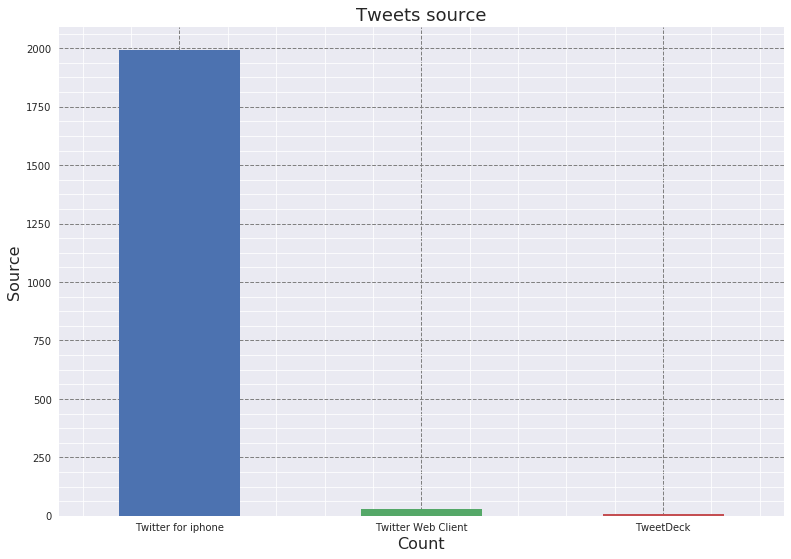

In [110]:

sns.set(style="darkgrid")
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='white', linestyle='-', alpha=0.8)

source = twitter_archive_master_df['source'].value_counts().plot(kind='bar',figsize=[13,9], )

plt.xlabel('Count', fontsize=16)
plt.xticks(rotation = 360)
plt.ylabel('Source', fontsize=16)
plt.title('Tweets source',fontsize=18)
plt.savefig('pictures/q1')

>This plot above shows the distribution of source. We can see that the dominate source of tweets is from iPhone twitter APP which is 94% in the total.

<div id='id72' />


**7.2 Which are the most added to favorites Internet_dog_terminology growing stages?**

We wonder if there is any kind of internet_dog_terminology (doggo, floofer, pupper, puppo) that is added with more frequency in favorites by users.

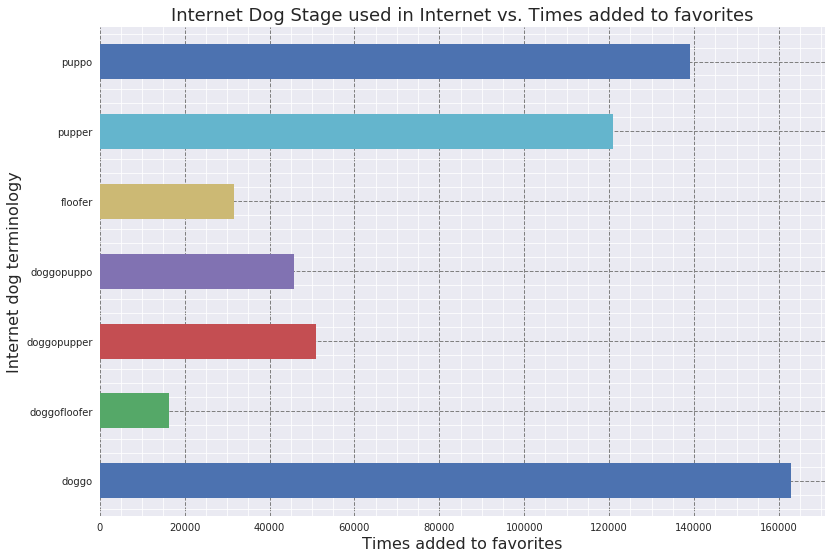

In [111]:

sns.set(style="darkgrid")
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='white', linestyle='-', alpha=0.8)

twitter_archive_master_df.groupby('internet_dog_terminology')['favorite_count'].max().plot(kind='barh',figsize=[13,9] )

plt.xlabel('Times added to favorites', fontsize=16)
plt.ylabel('Internet dog terminology', fontsize=16)
plt.title('Internet Dog Stage used in Internet vs. Times added to favorites',fontsize=18)
plt.savefig('pictures/q2')

> The most added to favorites internet dog terminology is doggo

<div id='id73' />

**7.3 Which are the most retweeted Internet_dog_terminology growing stages?**

Let's wonder if there is any kind of internet_dog_terminology (doggo, floofer, pupper, puppo) that is retweeted with more frequency  by users.





















































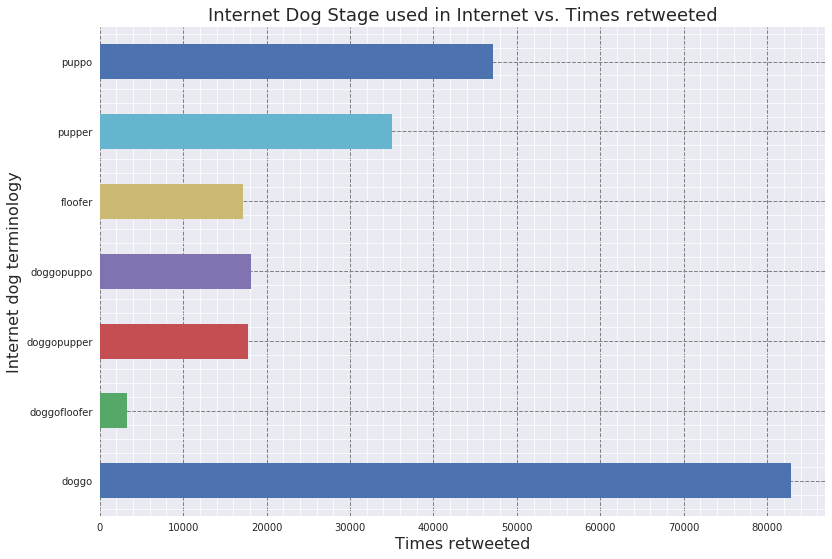

In [112]:

sns.set(style="darkgrid")
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='white', linestyle='-', alpha=0.8)

twitter_archive_master_df.groupby('internet_dog_terminology')['retweet_count'].max().plot(kind='barh', figsize=[13,9] )
plt.xlabel('Times retweeted', fontsize=16)
plt.ylabel('Internet dog terminology', fontsize=16)
plt.title('Internet Dog Stage used in Internet vs. Times retweeted',fontsize=18)
plt.savefig('pictures/q3')

>The most retweeted internet dog terminology is doggo

<div id='id74' />  


 
 **7.4. Is there a correlation between retweets and  additions to favorites?**

Let's evaluate a possible correlation between favorites addition and retweet

In [113]:
twitter_archive_master_df['favorite_count'].corr(twitter_archive_master_df['retweet_count'])

0.85655060180400411

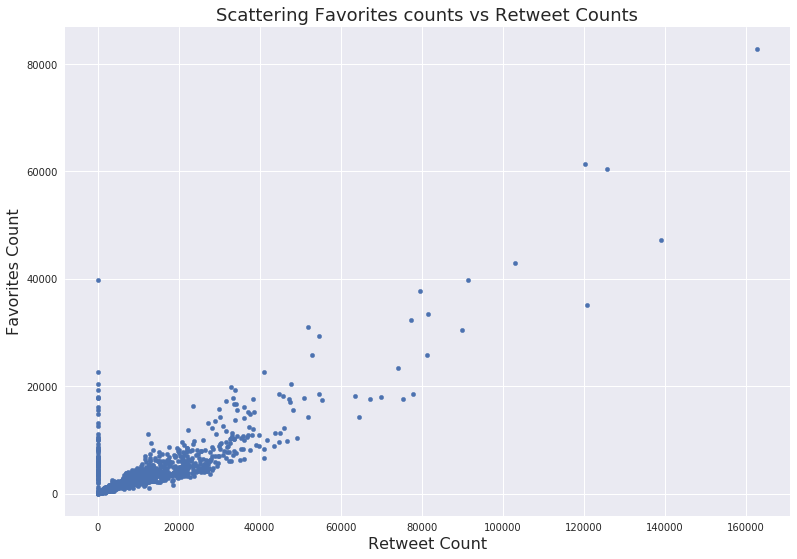

In [114]:
twitter_archive_master_df.plot('favorite_count', 'retweet_count', kind='scatter', figsize=[13,9] )

plt.xlabel("Retweet Count",fontsize=16)
plt.ylabel("Favorites Count",fontsize=16)
plt.title('Scattering Favorites counts vs Retweet Counts',fontsize=18)
plt.savefig('pictures/q4')

>With a result of 0.86 you can assume a **high correlation between favorites and retweets.**

<div id='id75' />

 
 **7.5 Which is the highest Internet dog terminology in terms of average rating?**

Invesrtigate if there is any kind of internet_dog_terminology (doggo, floofer, pupper, puppo) that is in average more rated

In [115]:
# groups the dataset by internet_dog_terminology and computes the average rating for each group
internet_dog_terminology_and_average_rating= twitter_archive_master_df.groupby('internet_dog_terminology')['rating_numerator'].mean().sort_values(ascending=False)



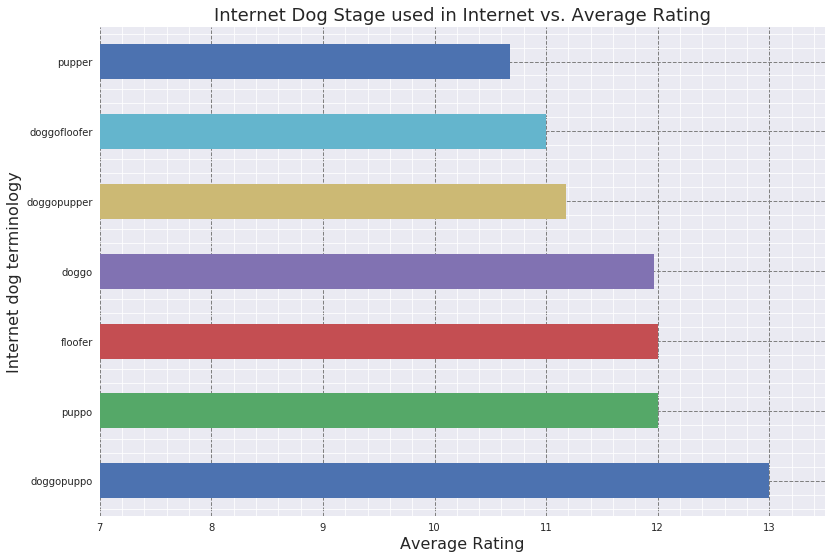

In [116]:

sns.set(style="darkgrid")
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='white', linestyle='-', alpha=0.8)
internet_dog_terminology_and_average_rating.plot(kind='barh', figsize=[13,9] , xlim=(7,13.5))
plt.xlabel("Average Rating",fontsize=16)
plt.ylabel("Internet dog terminology",fontsize=16)
plt.title('Internet Dog Stage used in Internet vs. Average Rating',fontsize=18)
plt.savefig('pictures/q5')

> The higest average rate correspond to the internet gog terminology doggopuppo

<div id='id76' />


**7.6. The most popular dog names are the names of the most retweeted dogs?**

In [117]:
#Investigate the most common names

twitter_archive_master_df.name.value_counts().head(10)

None       620
Lucy        10
Tucker      10
Cooper      10
Oliver      10
Charlie     10
Penny       10
Sadie        8
Lola         8
Bo           8
Name: name, dtype: int64

> The more usual names are: Tucker Cooper Charlie Oliver Lucy Penny

In [118]:
# Investigate the names of the most retweeted dogs

retweet_by_name = twitter_archive_master_df.groupby('name')['retweet_count'].mean().sort_values(ascending=False).head()

In [119]:
retweet_by_name

name
Stephan    60373.0
Duddles    43017.0
Jamesy     35080.0
Hurley     19880.0
quite      19412.0
Name: retweet_count, dtype: float64

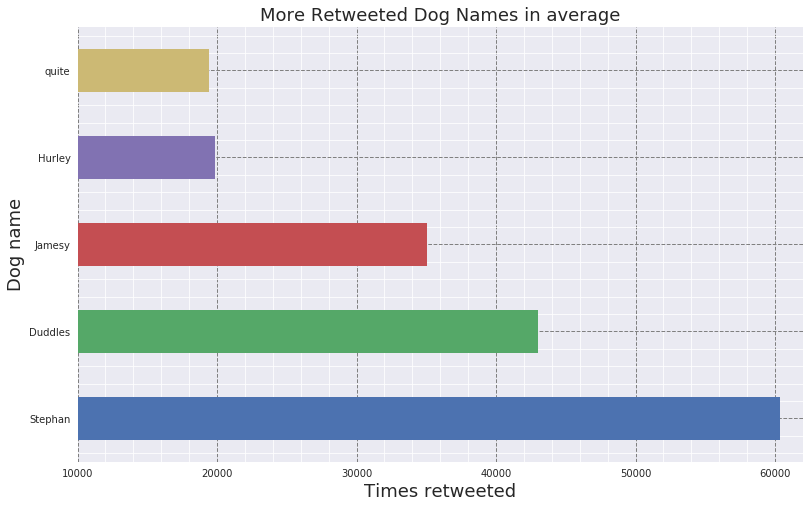

In [120]:

sns.set(style="darkgrid")
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='white', linestyle='-', alpha=0.8)

retweet_by_name.plot(kind='barh' , figsize=[13,8] , xlim=(10000,62000), alpha=1)
plt.xlabel("Times retweeted",fontsize=18)
plt.ylabel("Dog name",fontsize=18)
plt.title('More Retweeted Dog Names in average',fontsize=18)
plt.savefig('pictures/q6')

> The most retweeted dogs have not common names. So we can guess with a very soft and prudent manner that dog names have not a very significant influence in a  retweet desition.